# Plotting

Figures to plot:
1. Merit order plots showing:
    1. how emissions intensive plant move down the merit order as the permit price increases (subplot a), and the net liability faced by different generators if dispatched (subplot b);
    2. short-run marginal costs of generators under a REP scheme and a carbon tax.
    
2. Plot showing baselines that target average wholesale prices for different price targets over different permit price scenarios (subplot a). Plot showing scheme revenue arising from different baseline permit price combinations (subplot b). Plot showing final average wholesale prices (subplot c).

3. BAU targeting baseline and scheme revenue over a range of permit prices

4. Average emissions intensity as a function of permit price

5. Average regional prices under a BAU average wholesale price targeting REP scheme (subplot a), and a carbon tax (subplot b) for different permit prices.

## Import packages

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FormatStrFormatter, FixedLocator, LinearLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

Set text options for plots

In [2]:
matplotlib.rcParams['font.family'] = ['sans-serif']
matplotlib.rcParams['font.serif'] = ['Helvetica']
plt.rc('text', usetex=True)

## Declare paths to files

In [3]:
# Identifier used to update paths depending on the number of scenarios investigated
number_of_scenarios = '100_scenarios'

# Core data directory
data_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, 'data')

# Operating scenario data
operating_scenarios_dir = os.path.join(os.path.curdir, os.path.pardir, '1_create_scenarios')

# Model output directory
parameter_selector_dir = os.path.join(os.path.curdir, os.path.pardir, '2_parameter_selector', 'output', number_of_scenarios)

# Processed results directory
processed_results_dir = os.path.join(os.path.curdir, os.path.pardir, '3_process_results', 'output', number_of_scenarios)

# Output directory
output_dir = os.path.join(os.path.curdir, 'output', number_of_scenarios)

## Import data

In [4]:
# Model parameters
# ----------------
# Generator data
with open(os.path.join(parameter_selector_dir, 'df_g.pickle'), 'rb') as f:
    df_g = pickle.load(f)
    
# Node data
with open(os.path.join(parameter_selector_dir, 'df_n.pickle'), 'rb') as f:
    df_n = pickle.load(f)
    
# Scenario data
with open(os.path.join(parameter_selector_dir, 'df_scenarios.pickle'), 'rb') as f:
    df_scenarios = pickle.load(f)

    
# Processed results
# -----------------
# BAU average price
with open(os.path.join(processed_results_dir, 'mppdc_bau_average_price.pickle'), 'rb') as f:
    mppdc_bau_average_price = pickle.load(f)    
    
# Average system emissions intensities for different permit prices
with open(os.path.join(processed_results_dir, 'df_average_emissions_intensities.pickle'), 'rb') as f:
    df_average_emissions_intensities = pickle.load(f)
    
# Price targeting baselines for different permit prices
with open(os.path.join(processed_results_dir, 'df_baseline_vs_permit_price.pickle'), 'rb') as f:
    df_baseline_vs_permit_price = pickle.load(f)
    
# Scheme revenue corresponding to different price targets
with open(os.path.join(processed_results_dir, 'df_baseline_vs_revenue.pickle'), 'rb') as f:
    df_baseline_vs_revenue = pickle.load(f)
    
# Average regional and national wholesale electricity prices under a REP scheme
with open(os.path.join(processed_results_dir, 'df_rep_average_prices.pickle'), 'rb') as f:
    df_rep_average_prices = pickle.load(f)
    
# Average regional and national wholesale electricity prices under a carbon tax
with open(os.path.join(processed_results_dir, 'df_carbon_tax_average_prices.pickle'), 'rb') as f:
    df_carbon_tax_average_prices = pickle.load(f)

Conversion factor used to format figure size.

In [5]:
# Millimeters to inches
mmi = 0.0393701

### Merit order plots
Represent generators as rectangles. The length of a rectangle corresponds to a generator's capacity relative total installed capacity. Arrange these rectangles (generators) in order of increasing short-run marginal cost (SRMC), creating a merit order of generation. The colour and shade of each rectangle can be used to denote different generator properties e.g. emissions intensity, SRMC, or net liability faced under an output-based rebating scheme. Repeat this procedure for different permit price scenarios. Note that different permit prices will change the relative costs of generators, shifting their position in the merit order.

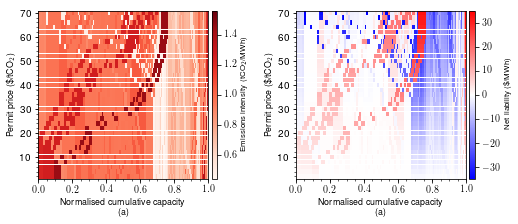

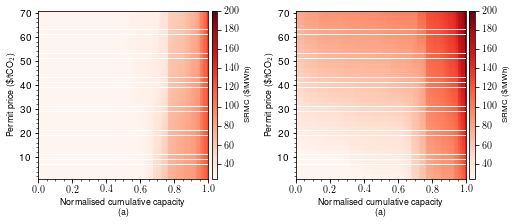

In [6]:
def plot_merit_order():
    "Shows how merit order is affected w.r.t emissions intensities, SRMCs, and net liability under a REP scheme"

    # Only consider fossil units
    df_gp = df_g[df_g['FUEL_CAT']=='Fossil'].copy()

    # Permit prices
    permit_prices = range(2, 71, 2)

    # Number of rectanlges
    n = len(permit_prices)

    # Gap as a fraction of rectangle height
    gap_fraction = 1 / 10

    # Rectangle height
    rectangle_height = 1 / (gap_fraction * (n - 1) + n)

    # Gap between rectangles
    y_gap = rectangle_height * gap_fraction

    # Initial y offset
    y_offset = 0

    # Container for rectangle patches
    rectangles = []

    # Container for colours corresponding to patches
    colours_emissions_intensity = []
    colours_net_liability = []
    colours_srmc_rep = []
    colours_srmc_carbon_tax = []

    # Construct rectangles to plot for each permit price scenario
    for permit_price in permit_prices:

        # Baseline corresponding to BAU price targeting scenario
        baseline = df_baseline_vs_permit_price.loc[permit_price, 1]

        # Net liability faced by generator under REP scheme
        df_gp['NET_LIABILITY'] = (df_gp['EMISSIONS'] - baseline) * permit_price

        # Compute updated SRMC and sort from least cost to most expensive (merit order)
        df_gp['SRMC_REP'] = df_gp['SRMC_2016-17'] + df_gp['NET_LIABILITY']
        df_gp.sort_values('SRMC_REP', inplace=True)

        # Carbon tax SRMCs (baseline = 0 for all permit price scenarios)
        df_gp['SRMC_TAX'] = df_gp['SRMC_2016-17'] + (df_gp['EMISSIONS'] * permit_price)

        # Normalising registered capacities
        df_gp['REG_CAP_NORM'] = (df_gp['REG_CAP'] / df_gp['REG_CAP'].sum())

        x_offset = 0

        # Plotting rectangles
        for index, row in df_gp.iterrows():
            rectangles.append(patches.Rectangle((x_offset, y_offset), row['REG_CAP_NORM'], rectangle_height))

            # Colour for emissions intensity plot
            colours_emissions_intensity.append(row['EMISSIONS'])

            # Colour for net liability under REP scheme for each generator
            colours_net_liability.append(row['NET_LIABILITY'])

            # Colour for net generator SRMCs under REP scheme
            colours_srmc_rep.append(row['SRMC_REP'])

            # Colour for SRMCs under carbon tax
            colours_srmc_carbon_tax.append(row['SRMC_TAX'])

            # Offset for placement of next rectangle
            x_offset += row['REG_CAP_NORM']
        y_offset += rectangle_height + y_gap

    # Merit order emissions intensity patches
    patches_emissions_intensity = PatchCollection(rectangles, cmap='Reds')
    patches_emissions_intensity.set_array(np.array(colours_emissions_intensity))

    # Net liability under REP scheme patches
    patches_net_liability = PatchCollection(rectangles, cmap='bwr')
    patches_net_liability.set_array(np.array(colours_net_liability))

    # SRMCs under REP scheme patches
    patches_srmc_rep = PatchCollection(rectangles, cmap='Reds')
    patches_srmc_rep.set_array(np.array(colours_srmc_rep))

    # SRMCs under carbon tax patches
    patches_srmc_carbon_tax = PatchCollection(rectangles, cmap='Reds')
    patches_srmc_carbon_tax.set_array(np.array(colours_srmc_carbon_tax))


    # Format tick positions
    # ---------------------
    # y-ticks
    # -------
    # Minor ticks
    yminorticks = []
    for counter, permit_price in enumerate(permit_prices):
        if counter == 0:
            position = rectangle_height / 2
        else:
            position = yminorticks[-1] + y_gap + rectangle_height
        yminorticks.append(position)
    yminorlocator = FixedLocator(yminorticks)

    # Major ticks
    ymajorticks = []
    for counter in range(0, 7):
        if counter == 0:
            position = (4.5 * rectangle_height) + (4 * y_gap)
        else:
            position = ymajorticks[-1] + (5 * rectangle_height) + (5 * y_gap)
        ymajorticks.append(position)
    ymajorlocator = FixedLocator(ymajorticks)

    # x-ticks
    # -------
    # Minor locator
    xminorlocator = LinearLocator(21)

    # Major locator
    xmajorlocator = LinearLocator(6)


    # Emissions intensity and net liability figure
    # --------------------------------------------
    plt.clf()

    # Initialise figure
    fig1 = plt.figure()

    # Axes on which to construct plots
    ax1 = plt.axes([0.065, 0.185, 0.40, .79])
    ax2 = plt.axes([0.57, 0.185, 0.40, .79])

    # Add emissions intensity patches
    ax1.add_collection(patches_emissions_intensity)

    # Add net liability patches
    patches_net_liability.set_clim([-35, 35])
    ax2.add_collection(patches_net_liability)

    # Add colour bars with labels
    cbar1 = fig1.colorbar(patches_emissions_intensity, ax=ax1, pad=0.015, aspect=30)
    cbar1.set_label('Emissions intensity (tCO${_2}$/MWh)', fontsize=8, fontname='Helvetica')

    cbar2 = fig1.colorbar(patches_net_liability, ax=ax2, pad=0.015, aspect=30)
    cbar2.set_label('Net liability (\$/MWh)', fontsize=8, fontname='Helvetica')

    # Label axes
    ax1.set_ylabel('Permit price (\$/tCO$_{2}$)', fontsize=9, fontname='Helvetica')
    ax1.set_xlabel('Normalised cumulative capacity\n(a)', fontsize=9, fontname='Helvetica')

    ax2.set_ylabel('Permit price (\$/tCO$_{2}$)', fontsize=9, fontname='Helvetica')
    ax2.set_xlabel('Normalised cumulative capacity\n(a)', fontsize=9, fontname='Helvetica')


    # Format ticks
    # ------------
    # y-axis
    ax1.yaxis.set_minor_locator(yminorlocator)
    ax1.yaxis.set_major_locator(ymajorlocator)
    ax2.yaxis.set_minor_locator(yminorlocator)
    ax2.yaxis.set_major_locator(ymajorlocator)

    # y-tick labels
    ax1.yaxis.set_ticklabels(['10', '20', '30', '40', '50', '60', '70'])
    ax2.yaxis.set_ticklabels(['10', '20', '30', '40', '50', '60', '70'])

    # x-axis
    ax1.xaxis.set_minor_locator(xminorlocator)
    ax1.xaxis.set_major_locator(xmajorlocator)
    ax2.xaxis.set_minor_locator(xminorlocator)
    ax2.xaxis.set_major_locator(xmajorlocator)

    # Format figure size
    width = 180 * mmi
    height = 75 * mmi
    fig1.set_size_inches(width, height)
    
    # Save figure
    fig1.savefig(os.path.join(output_dir, 'figures', 'emissions_liability_merit_order.pdf'))


    # SRMCs under REP and carbon tax
    # ------------------------------
    # Initialise figure
    fig2 = plt.figure()

    # Axes on which to construct plots
    ax3 = plt.axes([0.065, 0.185, 0.40, .79])
    ax4 = plt.axes([0.57, 0.185, 0.40, .79])

    # Add REP SRMCs
    patches_srmc_rep.set_clim([25, 200])
    ax3.add_collection(patches_srmc_rep)

    # Add carbon tax net liability
    patches_srmc_carbon_tax.set_clim([25, 200])
    ax4.add_collection(patches_srmc_carbon_tax)

    # Add colour bars with labels
    cbar3 = fig2.colorbar(patches_srmc_rep, ax=ax3, pad=0.015, aspect=30)
    cbar3.set_label('SRMC (\$/MWh)', fontsize=8, fontname='Helvetica')

    cbar4 = fig2.colorbar(patches_srmc_carbon_tax, ax=ax4, pad=0.015, aspect=30)
    cbar4.set_label('SRMC (\$/MWh)', fontsize=8, fontname='Helvetica')

    # Label axes
    ax3.set_ylabel('Permit price (\$/tCO$_{2}$)', fontsize=9, fontname='Helvetica')
    ax3.set_xlabel('Normalised cumulative capacity\n(a)', fontsize=9, fontname='Helvetica')

    ax4.set_ylabel('Permit price (\$/tCO$_{2}$)', fontsize=9, fontname='Helvetica')
    ax4.set_xlabel('Normalised cumulative capacity\n(a)', fontsize=9, fontname='Helvetica')


    # Format ticks
    # ------------
    # y-axis
    ax3.yaxis.set_minor_locator(yminorlocator)
    ax3.yaxis.set_major_locator(ymajorlocator)
    ax4.yaxis.set_minor_locator(yminorlocator)
    ax4.yaxis.set_major_locator(ymajorlocator)

    # y-tick labels
    ax3.yaxis.set_ticklabels(['10', '20', '30', '40', '50', '60', '70'])
    ax4.yaxis.set_ticklabels(['10', '20', '30', '40', '50', '60', '70'])

    # x-axis
    ax3.xaxis.set_minor_locator(xminorlocator)
    ax3.xaxis.set_major_locator(xmajorlocator)
    ax4.xaxis.set_minor_locator(xminorlocator)
    ax4.xaxis.set_major_locator(xmajorlocator)

    # Format figure size
    width = 180 * mmi
    height = 75 * mmi
    fig2.set_size_inches(width, height)

    # Save figure
    fig2.savefig(os.path.join(output_dir, 'figures', 'srmc_merit_order.pdf'))

    plt.show()
    
# Create figure
plot_merit_order()

### Price targeting baselines and corresponding scheme revenue
Plot emissions intensity baselines, scheme revenue, and average wholesale price outcomes for each permit price and wholesale price targeting scenario.

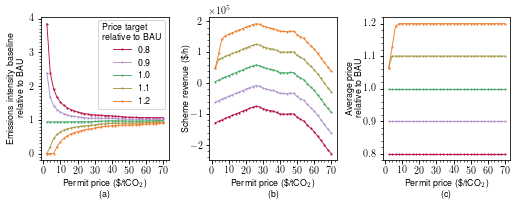

In [7]:
def plot_price_targeting_baselines_and_scheme_revenue():
    "Plot baselines that target given wholesale prices and scheme revenue that corresponds to these scenarios"

    # Initialise figure 
    plt.clf()
    fig = plt.figure()

    # Axes on which to construct plots
#     ax1 = plt.axes([0.08, 0.175, 0.41, 0.77])
#     ax2 = plt.axes([0.585, 0.175, 0.41, 0.77])
    
    ax1 = plt.axes([0.07, 0.21, 0.25, 0.72])
    ax2 = plt.axes([0.40, 0.21, 0.25, 0.72])
    ax3 = plt.axes([0.74, 0.21, 0.25, 0.72])

    # Price targets
    price_target_colours = {0.8: '#b50e43', 0.9: '#af92cc', 1: '#45a564', 1.1: '#a59845', 1.2: '#f27b2b'}

    
    # Price targeting baselines
    # -------------------------
    for col in df_baseline_vs_permit_price.columns:
        ax1.plot(df_baseline_vs_permit_price[col], '-x', markersize=1.5, linewidth=0.9, label=col, color=price_target_colours[col])

    # Label axes
    ax1.set_ylabel('Emissions intensity baseline\nrelative to BAU', fontsize=9)
    ax1.set_xlabel('Permit price (\$/tCO${_2}$)\n(a)', fontsize=9)

    # Format ticks
    ax1.xaxis.set_major_locator(MultipleLocator(10))
    ax1.xaxis.set_minor_locator(MultipleLocator(2))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.1))

    
    # Scheme revenue
    # --------------
    for col in df_baseline_vs_revenue.columns:
        ax2.plot(df_baseline_vs_revenue[col], '-x', markersize=1.5, linewidth=0.9, label=col, color=price_target_colours[col])

    # Label axes
    ax2.set_xlabel('Permit price (\$/tCO${_2}$)\n(b)', fontsize=9)
    ax2.set_ylabel('Scheme revenue (\$/h)', labelpad=0, fontsize=9)

    # Format axes
    ax2.ticklabel_format(axis='y', useMathText=True, style='sci', scilimits=(1, 5))
    ax2.xaxis.set_major_locator(MultipleLocator(10))
    ax2.xaxis.set_minor_locator(MultipleLocator(2))
    ax2.yaxis.set_minor_locator(MultipleLocator(20000))
    
    
    # Average prices
    # --------------
    # Final average price under different REP scenarios   
    df_final_prices = df_rep_average_prices.reset_index().pivot(index='FIXED_TAU', columns='TARGET_PRICE_BAU_MULTIPLE', values='NATIONAL').div(mppdc_bau_average_price)
    
    for col in df_final_prices.columns:
        ax3.plot(df_final_prices[col], '-x', markersize=1.5, linewidth=0.9, label=col, color=price_target_colours[col])
              
    # Label axes
    ax3.set_xlabel('Permit price (\$/tCO${_2}$)\n(c)', fontsize=9)
    ax3.set_ylabel('Average price\nrelative to BAU', labelpad=0, fontsize=9)
    
    # Format ticks
    ax3.xaxis.set_major_locator(MultipleLocator(10))
    ax3.xaxis.set_minor_locator(MultipleLocator(2))
    ax3.yaxis.set_minor_locator(MultipleLocator(0.02))

    # Create legend
    legend = ax2.legend(title='Price target\nrelative to BAU', ncol=1, loc='upper center', bbox_to_anchor=(-0.61, 1.01), fontsize=9)
    legend.get_title().set_fontsize('9')

    # Format figure size
    fig = ax2.get_figure()
    width = 180 * mmi
    height = 70 * mmi
    fig.set_size_inches(width, height)

    # Save figure
    fig.savefig(os.path.join(output_dir, 'figures', 'baseline_revenue_price_subplot.pdf'))
    plt.show()

# Create plot
plot_price_targeting_baselines_and_scheme_revenue()

Plot the BAU price targeting scenario. Overlay scheme revenue.

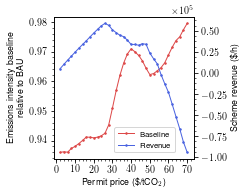

In [8]:
def plot_bau_price_target_and_baseline():
    "Plot baseline that targets BAU prices and scheme revenue on same figure"
    
    # Initialise figure
    plt.clf()
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    # Plot emission intensity baseline and scheme revenue
    df_bau_baseline_revenue = df_baseline_vs_permit_price[1].to_frame().rename(columns={1: 'baseline'}).join(df_baseline_vs_revenue[1].to_frame().rename(columns={1: 'revenue'}), how='left')
    df_bau_baseline_revenue['baseline'].plot(ax=ax1, color='#dd4949', markersize=1.5, linewidth=1, marker='o', linestyle='-')
    df_bau_baseline_revenue['revenue'].plot(ax=ax2, color='#4a63e0', markersize=1.5, linewidth=1, marker='o', linestyle='-')

    # Format axes labels
    ax1.set_xlabel('Permit price (\$/tCO$_{2}$)', fontsize=9)
    ax1.set_ylabel('Emissions intensity baseline\nrelative to BAU', fontsize=9)
    ax2.set_ylabel('Scheme revenue (\$/h)', fontsize=9)

    # Format ticks
    ax1.minorticks_on()
    ax2.minorticks_on()
    ax2.xaxis.set_major_locator(MultipleLocator(10))
    ax2.xaxis.set_minor_locator(MultipleLocator(2))
    ax2.ticklabel_format(axis='y', useMathText=True, style='sci', scilimits=(0, 1))

    # Format legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    l1 = ['Baseline']
    l2 = ['Revenue']
    ax1.legend(h1+h2, l1+l2, loc=0, bbox_to_anchor=(0.405, .25), fontsize=8)

    # Format figure size
    width = 85 * mmi
    height = 65 * mmi
    fig.subplots_adjust(left=0.22, bottom=0.16, right=0.8, top=.93)
    fig.set_size_inches(width, height)

    # Save figure
    fig.savefig(os.path.join(output_dir, 'figures', 'bau_price_target_baseline_and_revenue.pdf'))
    plt.show()

# Create figure
plot_bau_price_target_and_baseline()

### System emissions intensity as a function of permit price
Plot system emissions intensity as a function of permit price.

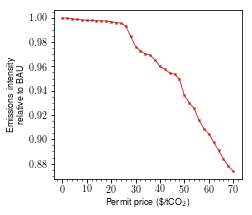

In [9]:
def plot_permit_price_vs_emissions_intensity():
    "Plot average emissions intensity as a function of permit price"
    
    # Initialise figure
    plt.clf()
    fig, ax = plt.subplots()

    # Plot figure
    df_average_emissions_intensities.div(df_average_emissions_intensities.iloc[0]).plot(linestyle='-', marker='x', markersize=2, linewidth=0.8, color='#c11111', ax=ax)

    # Format axis labels
    ax.set_xlabel('Permit price (\$/tCO${_2}$)', fontsize=9)
    ax.set_ylabel('Emissions intensity\nrelative to BAU', fontsize=9)

    # Format ticks
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.005))

    # Format figure size
    width = 85 * mmi
    height = width / 1.2
    fig.subplots_adjust(left=0.2, bottom=0.14, right=.98, top=0.98)
    fig.set_size_inches(width, height)
    
    # Save figure
    fig.savefig(os.path.join(output_dir, 'figures', 'permit_price_vs_emissions_intensity_normalised.pdf'))
    plt.show()
    
# Create figure
plot_permit_price_vs_emissions_intensity()

### Regional prices under REP scheme and carbon tax
Show regional impacts of the policy and compare with a carbon tax where rebates are not give to generators.

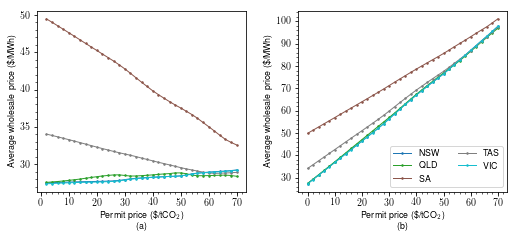

In [10]:
def plot_regional_prices_rep_and_tax():
    "Plot average regional prices under REP and carbon tax scenarios"
    
    # Initialise figure
    plt.clf()
    fig = plt.figure()
    ax1 = plt.axes([0.068, 0.18, 0.41, 0.8])
    ax2 = plt.axes([0.58, 0.18, 0.41, 0.8])

    # Regional prices under REP scheme
    df_rep_prices = df_rep_average_prices.loc[(slice(None), 1), :]
    df_rep_prices.index = df_rep_prices.index.droplevel(1)
    df_rep_prices.drop('NATIONAL', axis=1).plot(marker='o', linestyle='-', markersize=1.5, linewidth=1, cmap='tab10', ax=ax1)

    # Format labels
    ax1.set_xlabel('Permit price (\$/tCO${_2}$)\n(a)', fontsize=9)
    ax1.set_ylabel('Average wholesale price (\$/MWh)', fontsize=9)     

    # Format axes
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(MultipleLocator(2))
    ax1.xaxis.set_major_locator(MultipleLocator(10))

    # Add legend
    legend1 = ax1.legend()
    legend1.remove()

    # Plot prices under a carbon tax (baseline=0)
    df_carbon_tax_prices = df_carbon_tax_average_prices.copy()
    df_carbon_tax_prices.index = df_carbon_tax_prices.index.droplevel(1)
    
    # Rename columns - remove '1' at end of NEM region name
    new_column_names = {i: i.split('_')[-1].replace('1','') for i in df_carbon_tax_prices.columns}
    df_carbon_tax_prices = df_carbon_tax_prices.rename(columns=new_column_names)
    
    df_carbon_tax_prices.drop('NATIONAL', axis=1).plot(marker='o', linestyle='-', markersize=1.5, linewidth=1, cmap='tab10', ax=ax2)

    # Format axes labels
    ax2.set_ylabel('Average wholesale price (\$/MWh)', fontsize=9)
    ax2.set_xlabel('Permit price (\$/tCO${_2}$)\n(b)', fontsize=9)

    # Format ticks
    ax2.minorticks_on()
    ax2.xaxis.set_minor_locator(MultipleLocator(2))
    ax2.xaxis.set_major_locator(MultipleLocator(10))

    # Create legend
    legend2 = ax2.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.708, 0.28), fontsize=9)

    # Format figure size
    width = 180 * mmi
    height = 80 * mmi
    fig.set_size_inches(width, height)

    # Save figure
    fig.savefig(os.path.join(output_dir, 'figures', 'regional_wholesale_prices.pdf'))
    plt.show()
    
# Create figure
plot_regional_prices_rep_and_tax()